In [17]:
import pandas as pd
data = pd.read_csv('../dataset_customer_churn.csv', sep='^')
data.drop(labels=['A006_REGISTRO_ANS', 'CODIGO_BENEFICIARIO', 'CLIENTE', 'CD_USUARIO', 'CODIGO_FORMA_PGTO_MENSALIDADE', 'A006_NM_PLANO', 'DIAS_ATE_REALIZAR_ALTO_CUSTO', 'CD_ASSOCIADO', 'ESTADO_CIVIL'], axis=1, inplace=True)
is_NAN = data[data.isna().any(axis=1)]
data.drop(is_NAN.index, axis=0, inplace=True)
dict_replace = {
    "SIM": 1,
    "NAO": 0,
    'F': 0,
    'M': 1,
    'DESATIVADO': 1,
    'ATIVO': 0,

}
data.replace(dict_replace, inplace=True)
data.drop(labels=182212, axis=0, inplace=True)
data_dummified = pd.get_dummies(data)
data_dummified

,NUM_BENEFICIARIOS_FAMILIA,SITUACAO,IDADE,SEXO,QTDE_DIAS_ATIVO,QTDE_ATENDIMENTOS,QTDE_ATO_COBERTO_EXECUTADO,QTDE_ATO_N_COBERTO_EXECUTADO,REALIZOU_ENDODONTIA_COBERTA,REALIZOU_EXODONTIA_COBERTA,...,PLANO_422427992,PLANO_475441167,PLANO_475840164,PLANO_476697161,PLANO_476698169,PLANO_481484183,PLANO_481485181,PLANO_484629190,PLANO_703454997,PLANO_OUTROS
0,1.0,1,40.0,0,277.0,1.0,8.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,1,56.0,0,1725.0,2.0,10.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1,66.0,0,2006.0,18.0,73.0,8.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,1,62.0,1,529.0,1.0,1.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1.0,1,47.0,1,176.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386387,2.0,0,26.0,0,55.0,2.0,11.0,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0
386388,1.0,0,42.0,1,55.0,1.0,1.0,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0
386389,2.0,0,32.0,1,55.0,3.0,7.0,0.0,1,0,...,0,0,0,0,0,0,1,0,0,0
386390,1.0,1,37.0,0,833.0,1.0,5.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

x = data_dummified.drop(labels=['SITUACAO'], axis=1)
y = data_dummified['SITUACAO']
np.random.seed(1010)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, stratify=y)

In [19]:
from sklearn.linear_model import LogisticRegression
log_regression = LogisticRegression(max_iter=20000, penalty='l2', solver='newton-cg')
log_regression.fit(train_x,train_y)
predicts_rfc = log_regression.predict(test_x)

In [20]:
from sklearn.metrics import f1_score,recall_score,accuracy_score,precision_score
def all_scores(predicts, test_y):
    print(f"Accuracy Score: {accuracy_score(test_y,predicts):.3f}\nRecall Score: {recall_score(test_y,predicts):.3f}\nPrecision Score: {precision_score(test_y,predicts):.3f}\nF1 Score: {f1_score(test_y,predicts):.3f}\n")
def scores(validation_results):
    media = validation_results['test_score'].mean()
    desvio_padrao = validation_results['test_score'].std()
    print("Accuracy médio {:.2f}".format(media))
    print("Intervalo [{:.2f}, {:.2f}]".format((media - 2 * desvio_padrao), (media + 2 * desvio_padrao)))

In [21]:
all_scores(predicts_rfc, test_y)

Accuracy Score: 0.827
Recall Score: 0.841
Precision Score: 0.842
F1 Score: 0.841



In [ ]:
from sklearn.model_selection import cross_validate, KFold

validation_results = cross_validate(log_regression,x,y,cv=KFold(n_splits=10, shuffle=True))
scores(validation_results)
validation_results_df = pd.DataFrame(validation_results)
validation_results_df

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=log_regression, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [10]:
log_regression.coef_

array([[-1.09279407e-02,  1.03620841e-03, -5.77320602e-02,
        -1.83430630e-03, -1.29255169e-01,  3.51632132e-02,
         6.14153212e-02, -3.71111011e+00, -2.65510107e-01,
         1.22193081e+01,  2.08782422e+00, -8.81016310e-01,
        -3.30125551e+00, -7.42175605e-01,  2.43083931e-01,
         3.41836861e+00, -8.24828438e-01,  1.19842381e+00,
         3.13097651e+00, -8.14826967e-01, -6.05177781e-01,
         3.88539963e-02, -6.43513006e-02, -1.25352453e+00,
        -2.53008377e+00, -1.95887866e+00,  2.01700308e+00,
         8.41586524e-01]])

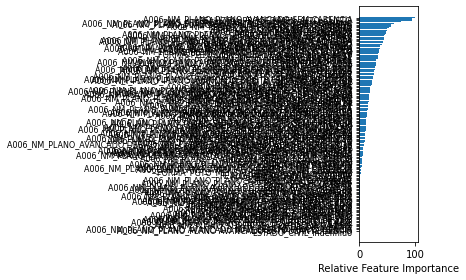